# Kotta Demo V2.0


In [1]:
# Import the Kotta module
from kotta import Kotta, KottaJob
from kotta.kotta_functions import *

# Create a Kotta Connection using Login with Amazon credentials

konn = Kotta('< MAKE SURE YOU PUT YOUR TOKENS HERE >')

## Round 1. Extract yearly info from the contributors table.

This gets you (publication_id, author_id, full_name, year)

In [2]:

extract_script = '''#!/bin/bash
apt-get -y install mysql-client-5.6;
YEAR=$1
mysql -h wos2.cvirc91pe37a.us-east-1.rds.amazonaws.com -P 3306 -u $wosuser -p$wospasswd -e "use wos; SELECT wos_id, cluster_id, full_name FROM $1_contributors 
WHERE cluster_id NOT LIKE 'NULL' ;" > $1_extract.tsv '''


extract_2011 = KottaJob( jobtype            = 'script',                      
                         jobname            = 'Extract 2011',                                   
                         outputs            = ['2011_extract.tsv'],                        
                         executable         = '/bin/bash myscript.sh 2011',
                         script_name        = 'myscript.sh',                         
                         script             =  extract_script
                       )
extract_2012 = KottaJob( jobtype            = 'script',                      
                         jobname            = 'Extract 2012',                                   
                         outputs            = ['2012_extract.tsv'],                                
                         executable         = '/bin/bash myscript.sh 2012',
                         script_name        = 'myscript.sh',                         
                         script             =  extract_script
                       )
extract_2013 = KottaJob( jobtype            = 'script',                      
                         jobname            = 'Extract 2013',                                   
                         outputs            = ['2013_extract.tsv'],       
                         executable         = '/bin/bash myscript.sh 2013',
                         script_name        = 'myscript.sh',                         
                         script             =  extract_script
                       )
extract_2014 = KottaJob( jobtype            = 'script',                      
                         jobname            = 'Extract 2014',                                   
                         outputs            = ['2014_extract.tsv'],       
                         executable         = '/bin/bash myscript.sh 2014',
                         script_name        = 'myscript.sh',                         
                         script             =  extract_script
                       )
extract_2015 = KottaJob( jobtype            = 'script',                      
                         jobname            = 'Extract 2015',                                   
                         outputs            = ['2015_extract.tsv'],       
                         executable         = '/bin/bash myscript.sh 2015',
                         script_name        = 'myscript.sh',                         
                         script             =  extract_script
                       )

# Now to manage these jobs better, let's put them in a list
round1_jobs = [extract_2011, extract_2012, extract_2013, extract_2014, extract_2015]

In [3]:
# Let's run these extraction routines on Kotta
for job in round1_jobs:
    job.submit(konn)    

In [ ]:
# If the tasks we submit are short tasks, we can easily check for the status
# by calling the JOB.status(<Kotta_conn>) 
for job in round1_jobs:
    print('{0} {1}'.format(job.job_id, job.status(konn)))

In [5]:
# Or more conveniently we have a wait function
[job.wait(konn) for job in round1_jobs]

['completed', 'completed', 'completed', 'completed', 'completed']

In [6]:
for job in round1_jobs:
    print(job.outputs[0].s3_url)

s3://klab-jobs/outputs/4383cb45-7346-46c7-8d58-875f3419df69/2011_extract.tsv
s3://klab-jobs/outputs/0487fe11-8009-4db1-b917-d2ae5f31e5bb/2012_extract.tsv
s3://klab-jobs/outputs/dee6c714-92ea-472a-85be-b7f82da5e635/2013_extract.tsv
s3://klab-jobs/outputs/b6f42117-b8be-48a3-ab50-3c2d8118fdf3/2014_extract.tsv
s3://klab-jobs/outputs/39f926df-9f75-4beb-ac42-61f17b64b5e0/2015_extract.tsv


## Round 2. Merge and Analyze the data from [2011..2015]

We now have the data from the year 2011...2015, which is a lot of data. So we trim this down by aggregating
and selecting just the top authors. Python does these sorts of tasks very well. Let's see how to do python
on Kotta directly from a Jupyter Notebook.

In [7]:
round2_inputs = [job.outputs[0].s3_url for job in round1_jobs]

### Inputs to the Kotta and Arguments passed to the python function

Inputs to the @kottajob decorator are files that show up in the working directory of the analysis.
Arguments passed to the python function are serialized and show up on the execution side.
Note that we are passing the outputs from round1 (Extraction) as inputs to round2.

In [8]:
%%time

@kottajob(konn, 'Test', 10, inputs=round2_inputs, block=True)
def list_cwd():
    import os;
    return os.listdir('.')

result = list_cwd()
print(result)

['serialize', 'a7c5d56a-834a-4040-bd95-8c21741b058a.in.pkl', '2015_extract.tsv', 'exec_wait.out.txt', '2011_extract.tsv', 'serialize.tar.gz', 'exec.sh', '2014_extract.tsv', '2012_extract.tsv', 'exec_wait.err.txt', 'runner.py', '2013_extract.tsv', 'STDERR.txt', 'STDOUT.txt']
CPU times: user 72.6 ms, sys: 22.8 ms, total: 95.4 ms
Wall time: 25.6 s


In [9]:
%load_ext autoreload
%autoreload 2

from kotta.kotta_functions import *

In [10]:
@kottajob(konn, 'Prod', 60, inputs=round2_inputs, outputs=['sorted.pkl'], block=True)
def Merge_and_Analyze (datadir='.', top_N=10, outfile='sorted.pkl'):
    import os
    import csv
    import pickle

    sources    = [f for f in os.listdir(datadir) if f.endswith('_extract.tsv')]
    delimiter  = '\t'
    data       = []
    for source in sources:
        year = int(source[0:4])
        with open(source, 'r') as f:
            headers = f.readline().strip().split(delimiter)
            reader = csv.DictReader(f, delimiter=delimiter, fieldnames=headers)
            current = list(reader)
            for row in current:
                row['year'] = year
            data.extend(current)

    print("Analyzing {0} entries".format(len(data)))

    # Do counting                                                                                                                                                                                                    
    counts = {}
    for row in data:
        cid = row['cluster_id']
        if row['cluster_id'] not in counts :
            counts[cid] = {'data' : row, 'count' : 0}
        counts[cid]['count'] += 1


    # Print unique clusters                                                                                                                                                                                          
    print("Unique cluster_ids : ", len(counts.keys()))

    # Sort by authors based on total publications                                                                                                                                                                    
    sorted_auths = sorted(counts, key=lambda k : counts[k]['count'])

    results = {}
    for cid in sorted_auths[-(top_N):]:
        pubs = [{'wos_id' : row['wos_id'],
                 'year'   : row['year'] } for row in data if row['cluster_id'] == cid]
        results[cid] = {'pubs' :  pubs,
                           'info' : counts[cid]
                          }

    with open(outfile, 'wb') as outf:
        pickle.dump(results, outf)
    return results


merged_results = Merge_and_Analyze(datadir='.', top_N=10, outfile='sorted.pkl')


In [11]:
for author_id in merged_results:
    print("AuthorID:{0:10} Name:{1:20} PubCount:{2:5}".format(author_id,
                                                      merged_results[author_id]['info']['data']['full_name'],
                                                      merged_results[author_id]['info']['count']))

AuthorID:3286000    Name:Zhang, Jie           PubCount: 8107
AuthorID:3331600    Name:Lee, Sungwoo         PubCount: 6667
AuthorID:3324000    Name:Zhang, Lei           PubCount: 6449
AuthorID:1218500    Name:Wang, Hong           PubCount: 5363
AuthorID:3370100    Name:Li, Juan             PubCount: 9552
AuthorID:1220800    Name:Wang, Ling           PubCount: 6234
AuthorID:3346800    Name:Kim, Jonggun         PubCount: 7882
AuthorID:909800     Name:Zhang, Hongyan       PubCount: 5941
AuthorID:3329587    Name:Kim, Hangil          PubCount: 6994
AuthorID:3327300    Name:Zhang, Yi            PubCount:11057


## Round 3 

Now for the top N authors, we have their publications, we have to find the funding sources associated with each of their publications.
This involves a time consuming query operation that can be easily parallelized. We give each author's information to different Kotta Job which query the database in parallel.


In [18]:
@kottajob(konn, 'Test', 10, block=True)
def get_funding_for_author(data, outfile='final.pkl', wosuser=None, wospasswd=None):

    import os
    import pymysql.cursors
    import pickle
    import copy

    wos_user   = wosuser   if wosuser   else os.environ['wosuser']
    wos_passwd = wospasswd if wospasswd else os.environ['wospasswd']
          
    connection = pymysql.connect(host        = 'wos2.cvirc91pe37a.us-east-1.rds.amazonaws.com',
                                 user        = wos_user,
                                 password    = wos_passwd,
                                 db          = 'wos',
                                 charset     = 'utf8mb4',
                                 cursorclass = pymysql.cursors.DictCursor)

    try:
        with connection.cursor() as cursor:
            for author in data.keys():
                print("Getting author : {0} items:{1}".format(author, len(data[author]['pubs'])))
                count = 0
                for pubs in data[author]['pubs'][:50]:
                    sql = "select agency from {0}_funding where wos_id = '{1}' ;".format(pubs['year'], 
                                                                                         pubs['wos_id'])                                                                                                                                                                                            
                    cursor.execute(sql)   
                    pubs['agency'] = cursor.fetchall()
                    print("Item : {0} ", count); count += 1
    finally:
        connection.close()

    #pickle.dump(data, open(outfile, 'wb'))                                                                                                                                                                          
    print("Done")
    return data


funding_data = get_funding_for_author(merged_results)


In [21]:
# Checking sanity of results
print(len(funding_data['3286000']['pubs']))

8107


## Round 4 

Vizualize the results

In [26]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import pickle as pkl
import operator

''' Kotta Author Data
'''

# In case the SQL query takes too long, use the Pickled results

'''
pkl_fp  = open('/home/yadu/TuringClient/demo/final.pkl', 'rb')
raw_author_agencies = pkl.load(pkl_fp)
pkl_fp.close()
'''
raw_author_agencies  = funding_data

#print(raw_author_agencies['1218500'])
''' Graph initialization
'''
G = nx.Graph()

colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c", 
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#ffff00"])


year_mapping = {2010: colormap[5],
                2011: colormap[1], 
                2012: colormap[2],
                2013: colormap[3],
                2014: colormap[4],
                2015: colormap[0]}

''' Find the authors, and gather the frequencies to find the most frequently appearing agencies
'''
authors = [author_id for author_id in raw_author_agencies]
agencies = []
freqs = {}
for author_id in raw_author_agencies:
    info = raw_author_agencies[author_id]
    for pub in info['pubs']:
        for agency in pub.get('agency', []):
            agencies += [agency['agency']]
            if agency['agency'] in freqs:
                freqs[agency['agency']] += 1
            else:
                freqs[agency['agency']] = 1
agencies = [agency[0] for agency in sorted(freqs.items(), key=operator.itemgetter(1), reverse=True)[:10]]

''' Build the edgelist for the graph
'''
author_agencies = []
for author_id in raw_author_agencies:
    info = raw_author_agencies[author_id]
    for pub in info['pubs']:
        for agency in pub.get('agency', []):
            if agency['agency'] in agencies:
                author_agencies += [(author_id, agency['agency'], {'year':pub['year']})]
author_agencies= sorted(author_agencies, key=lambda x: x[2]['year'], reverse=True) # sort by decreasing year, to make sure the edge gets colored by the earliest year

''' Compute the edge weights (number of times an author & agency appear)
'''
weights = {(edge[0], edge[1]): len([uv for uv in author_agencies if (uv[0] == edge[0] and uv[1] == edge[1]) 
                                                  or (uv[1] == edge[0] and uv[0] == edge[1])]) for edge in author_agencies}
      
''' Add the nodes & edges to the graph
'''
G.add_nodes_from(authors)
G.add_nodes_from(agencies)
G.add_edges_from(author_agencies)

''' Assign the weights to the edges, and scale accordingly
'''
max_weight = max([weights[x] for x in weights])
for weight in weights:
    G[weight[0]][weight[1]]['width'] =  8. * (weights[weight] / max_weight)# / min_weight)

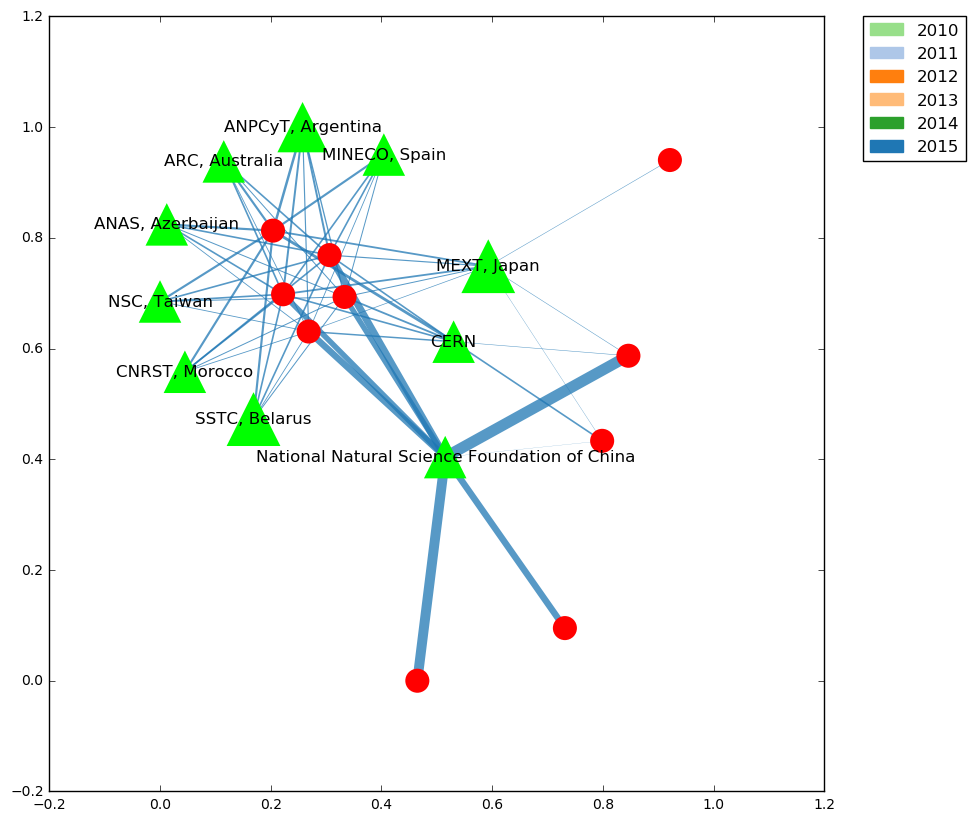

In [27]:
%matplotlib inline
pos = nx.spring_layout(G, weight=None)

fig, ax = plt.subplots(1,1, figsize=(10,10))

'''Add the year-color mapping legend
'''
patches = []
for year in year_mapping:
    patch = mpatches.Patch(color=year_mapping[year], label=year)
    patches += [patch]

''' Assign the color nodes -- Green to agency, Red to author
'''
agency_color = ['#00FF00'] * len(agencies)
author_color = ['#FF0000'] * len(authors)
max_degree = max([degree for degree in G.degree(sorted(agencies)).values()])

''' Draw agencies
    - Scale size by degree
'''
nx.draw_networkx_nodes(G, pos=pos, ax=ax, linewidths=0, 
                       node_size=[1500*float(degree/max_degree) for degree in G.degree(sorted(agencies)).values()], 
                       nodelist=sorted(agencies), 
                       node_color=agency_color, 
                       node_shape='^')

''' Draw authors
'''
nx.draw_networkx_nodes(G, pos=pos, ax=ax, linewidths=0,nodelist=authors, node_color=author_color)

''' Draw edges
    - Scale width of edge by precomputed weight
    - Color edge by earliest year
'''
nx.draw_networkx_edges(G, pos=pos, ax=ax, 
                       width=[G[edge[0]][edge[1]]['width'] for edge in G.edges_iter()], 
                       edge_color=[year_mapping[G[edge[0]][edge[1]]['year']] for edge in G.edges_iter()],
                       alpha=0.75)
''' Draw agency names
'''
nx.draw_networkx_labels(G, pos=pos, ax=ax, labels={agency_name:agency_name for agency_name in agencies})

plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


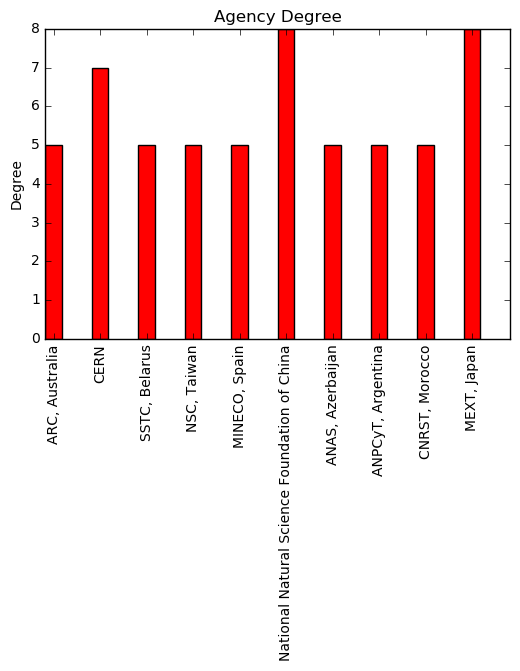

In [28]:
%matplotlib inline

N = len(agencies)
degree_dist = G.degree(sorted(agencies)).values()

ind = np.arange(N)  
width = 0.35       

fig, ax = plt.subplots()
rects1 = ax.bar(ind, degree_dist, width, color='r')

ax.set_ylabel('Degree')
ax.set_title('Agency Degree')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(G.degree(sorted(agencies)).keys(), rotation='vertical')
